In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import rasterio
import numpy as np
import yaml
import os
import seaborn as sns

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

##### Reproject elevation data for consistency

In [3]:
# Path to the .adf file
elevation_path = resolve_path(config['Africa_Elevation_rast_path'])

# Open the .adf file using rasterio
with rasterio.open(elevation_path) as src:
    # Identify the CRS of the DEM
    dem_crs = src.crs
    transform = src.transform
    elevation_data = src.read(1)  # Read the first band
    gradient_y, gradient_x = np.gradient(elevation_data, src.res[1], src.res[0])

# Open the .adf file using rasterio and reproject to EPSG:3857
with rasterio.open(elevation_path) as src:
    dem_crs = src.crs
    if dem_crs != "EPSG:3857":
        transform, width, height = calculate_default_transform(
            src.crs, "EPSG:3857", src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': "EPSG:3857",
            'transform': transform,
            'width': width,
            'height': height,
            'driver': 'GTiff'
        })

        with rasterio.open(resolve_path(config['Africa_Elevation_Reprojected_tif_path']), 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs="EPSG:3857",
                    resampling=Resampling.nearest)
   

##### Load and check the crs of the rest of the data

In [4]:
# Load the reprojected dam gdf
gdf_dams_path = resolve_path(config['Africa_Dam_Reproj_shp_path'])
gdf_dams = gpd.read_file(gdf_dams_path)
print(gdf_dams.crs)

# Load the reprojected CPIS gdf
gdf_cpis_path = resolve_path(config['Combined_CPIS_Reproj_shp_path'])
gdf_cpis = gpd.read_file(gdf_cpis_path)
print(gdf_cpis.crs)

# Load the reprojected Area Equipt for Irrigation (AEI) gdf
gdf_aei_path = resolve_path(config['AEI_2015_reproj_gpkg_path'])
gdf_aei = gpd.read_file(gdf_aei_path)
print(gdf_cpis.crs)

# Load the reprojected Cropland gdf
gdf_cropland_path = resolve_path(config['Arid_Cropland_by_Country_shp_path'])
gdf_cropland = gpd.read_file(gdf_cropland_path)
print(gdf_cropland.crs)

EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


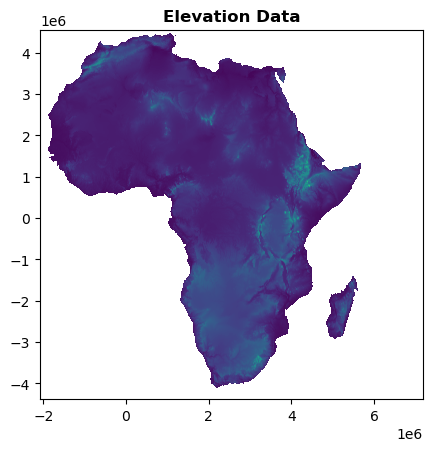

In [5]:

# Load elevation data
elevation_tif_path = resolve_path(config['Africa_Elevation_Reprojected_tif_path'])
with rasterio.open(elevation_tif_path) as src:
    elevation_data = src.read(1)
    elevation_transform = src.transform
    show(src, title="Elevation Data")

# Calculate the gradient of the elevation data
gradient_y, gradient_x = np.gradient(elevation_data, elevation_transform[0], elevation_transform[4])

# Calculate the direction of the gradient
gradient_direction = np.arctan2(gradient_y, gradient_x)

# Normalize to degrees
gradient_direction_degrees = np.degrees(gradient_direction)

In [6]:
# Function to classify upstream or downstream
def classify_stream_position(gdf, dams_gdf, gradient_direction, transform):
    positions = []
    for index, row in gdf.iterrows():
        point = row.geometry.centroid
        row, col = ~transform * (point.x, point.y)
        row, col = int(row), int(col)

        if gradient_direction[row, col] > 0:  # Adjust this condition as needed based on your gradient direction interpretation
            positions.append('downstream')
        else:
            positions.append('upstream')
    return positions

# Function to calculate distances
def calculate_distances(src_gdf, target_gdf):
    src_centroids = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_centroids, k=1)
    
    return dists

# Calculate positions
positions_cpis = classify_stream_position(gdf_cpis, gdf_dams, gradient_direction_degrees, elevation_transform)
positions_aei = classify_stream_position(gdf_aei, gdf_dams, gradient_direction_degrees, elevation_transform)
positions_cropland = classify_stream_position(gdf_cropland, gdf_dams, gradient_direction_degrees, elevation_transform)

# Calculate distances
distances_cpis_to_dams = calculate_distances(gdf_cpis, gdf_dams)
distances_aei_to_dams = calculate_distances(gdf_aei, gdf_dams)
distances_cropland_to_dams = calculate_distances(gdf_cropland, gdf_dams)


In [7]:
# Function to adjust distances for upstream/downstream classification
def adjust_distances(distances, positions):
    adjusted_distances = []
    for distance, position in zip(distances, positions):
        if position == 'upstream':
            adjusted_distances.append(-distance)  # Negative for upstream
        else:
            adjusted_distances.append(distance)  # Positive for downstream
    return adjusted_distances

# Adjust distances for plotting
adjusted_distances_cropland = adjust_distances(distances_cropland_to_dams, positions_cropland)
adjusted_distances_cpis = adjust_distances(distances_cpis_to_dams, positions_cpis)
adjusted_distances_aei = adjust_distances(distances_aei_to_dams, positions_aei)

# DataFrames for plotting
df_cropland_vs_cpis = pd.DataFrame({
    'distance': adjusted_distances_cropland + adjusted_distances_cpis,
    'type': ['Cropland'] * len(adjusted_distances_cropland) + ['CPIS'] * len(adjusted_distances_cpis)
})

# Convert distances from meters to kilometers
df_cropland_vs_cpis['distance_km'] = df_cropland_vs_cpis['distance'] / 1000

df_aei_vs_cpis = pd.DataFrame({
    'distance': adjusted_distances_aei + adjusted_distances_cpis,
    'type': ['AEI'] * len(adjusted_distances_aei) + ['CPIS'] * len(adjusted_distances_cpis)
})

# Convert distances from meters to kilometers
df_aei_vs_cpis['distance_km'] = df_aei_vs_cpis['distance'] / 1000

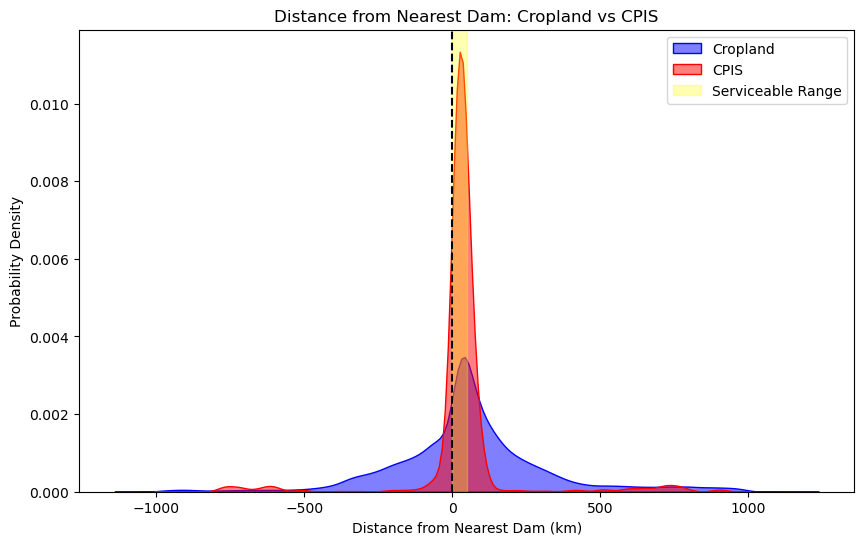

In [8]:
# Plot cropland vs CPIS with x-axis in kilometers
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_cropland_vs_cpis[df_cropland_vs_cpis['type'] == 'Cropland'], x='distance_km', fill=True, common_norm=False, alpha=0.5, label='Cropland', color='blue')
sns.kdeplot(data=df_cropland_vs_cpis[df_cropland_vs_cpis['type'] == 'CPIS'], x='distance_km', fill=True, common_norm=False, alpha=0.5, label='CPIS', color='red')
plt.axvline(x=0, linestyle='--', color='black')
plt.xlabel('Distance from Nearest Dam (km)')
plt.ylabel('Probability Density')
plt.title('Distance from Nearest Dam: Cropland vs CPIS')
plt.legend(title='Type')

# Highlight the serviceable range (up to 50 km downstream)
serviceable_range_km = 50  # 50 km
plt.axvspan(0, serviceable_range_km, color='yellow', alpha=0.3, label='Serviceable Range')

plt.legend()
plt.show()

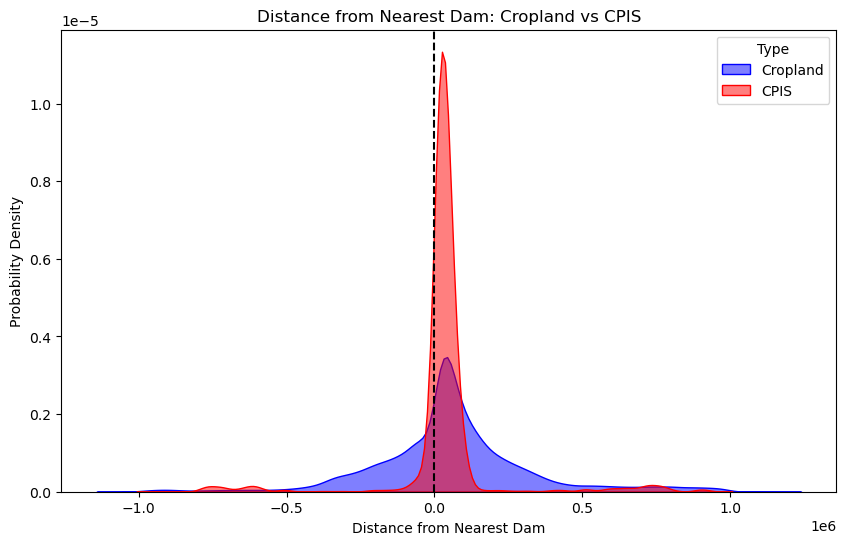

In [9]:

# Plot cropland vs CPIS
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_cropland_vs_cpis[df_cropland_vs_cpis['type'] == 'Cropland'], x='distance', fill=True, common_norm=False, alpha=0.5, label='Cropland', color='blue')
sns.kdeplot(data=df_cropland_vs_cpis[df_cropland_vs_cpis['type'] == 'CPIS'], x='distance', fill=True, common_norm=False, alpha=0.5, label='CPIS', color='red')
plt.axvline(x=0, linestyle='--', color='black')
plt.xlabel('Distance from Nearest Dam')
plt.ylabel('Probability Density')
plt.title('Distance from Nearest Dam: Cropland vs CPIS')
plt.legend(title='Type')
plt.show()


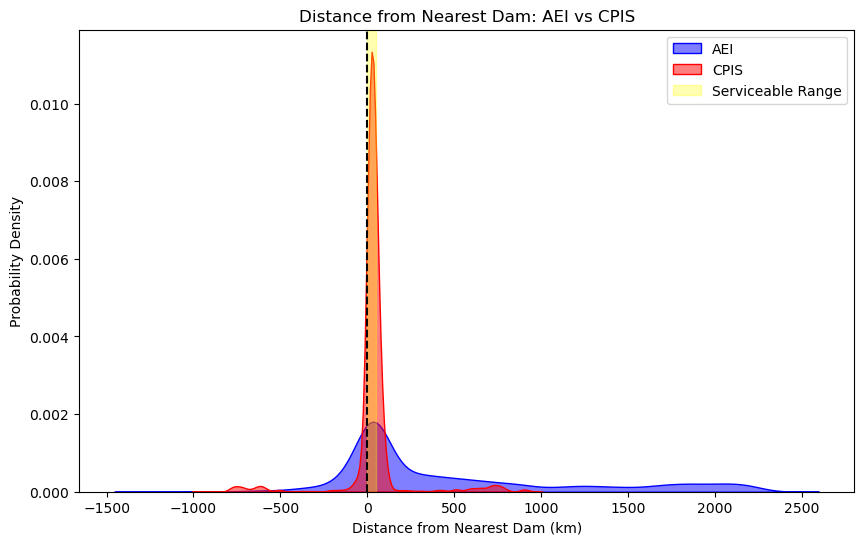

In [10]:
# Plot AEI vs CPIS with x-axis in kilometers
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_aei_vs_cpis[df_aei_vs_cpis['type'] == 'AEI'], x='distance_km', fill=True, common_norm=False, alpha=0.5, label='AEI', color='blue')
sns.kdeplot(data=df_aei_vs_cpis[df_aei_vs_cpis['type'] == 'CPIS'], x='distance_km', fill=True, common_norm=False, alpha=0.5, label='CPIS', color='red')
plt.axvline(x=0, linestyle='--', color='black')
plt.xlabel('Distance from Nearest Dam (km)')
plt.ylabel('Probability Density')
plt.title('Distance from Nearest Dam: AEI vs CPIS')
plt.legend(title='Type')

# Highlight the serviceable range (up to 50 km downstream)
serviceable_range_km = 50  # 50 km
plt.axvspan(0, serviceable_range_km, color='yellow', alpha=0.3, label='Serviceable Range')

plt.legend()
plt.show()

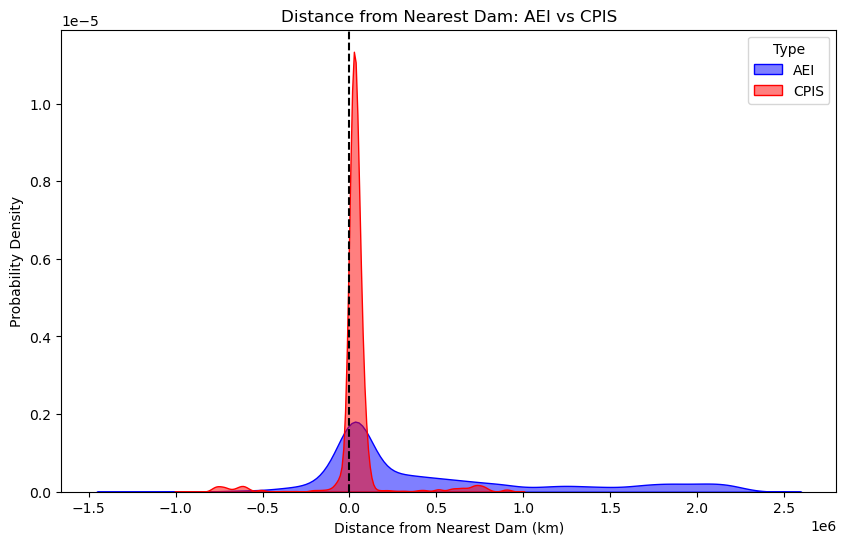

In [11]:


# Plot AEI vs CPIS
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_aei_vs_cpis[df_aei_vs_cpis['type'] == 'AEI'], x='distance', fill=True, common_norm=False, alpha=0.5, label='AEI', color='blue')
sns.kdeplot(data=df_aei_vs_cpis[df_aei_vs_cpis['type'] == 'CPIS'], x='distance', fill=True, common_norm=False, alpha=0.5, label='CPIS', color='red')
plt.axvline(x=0, linestyle='--', color='black')
plt.xlabel('Distance from Nearest Dam (km)')
plt.ylabel('Probability Density')
plt.title('Distance from Nearest Dam: AEI vs CPIS')
plt.legend(title='Type')
plt.show()
